Comparing HARMONIE and WOW-NL
=============================

This notebook shows how to compare HARMONIE's deterministic forecast with WOW-NL observations. In this case we are focusing on night temperatures during a heatwave in July 2019. We first located and uploaded Harmonie's forecast into the virtual research environment storage and we coupled this with the hourly aggregations of WOW-NL, so that we show the temperature differences between what was forecasted and what was actually measured.

In [1]:
import sys
import os
import datetime
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("User Current Version:-", sys.version)

User Current Version:- 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:17) [GCC 12.2.0]


## We read all hourly aggregations for the heatwave period coming from the WOW-NL network

In [2]:
# Toggle the following to switch between the heatwave or the desert dust use case
path_in_wow = r"/home/jovyan/work/aggregations/{0}"
file_template = r"{0}aggregation_60min.csv"

sta_date = datetime.datetime(2019, 7, 20)
end_date = datetime.datetime(2019, 8, 1)

time_range_days = pd.date_range(start=sta_date, end=end_date, freq="D")

df_60m_temp = pd.DataFrame()
for date in time_range_days:
    cur_file = file_template.format(date.strftime("%Y-%m-%d"))
    cur_path = path_in_wow.format(cur_file)
    df = pd.read_csv(cur_path, sep=",", header=[0, 1], index_col=[0, 1, 2])
    df = df["DryBulbTemperature_Celsius"] # Now columns are: ['Latitude', 'Longitude', 'CreatedDateTime', 'mean', 'min', 'max']
    df = df.reset_index(inplace=False)
    df.CreatedDateTime = pd.to_datetime(df.CreatedDateTime, utc=False) # Comment the UTC part for the WOW data of 2019
    df.CreatedDateTime = df.CreatedDateTime.apply(lambda x: x.replace(tzinfo=None))
    df.CreatedDateTime.astype('datetime64[ns]')
    df_60m_temp = pd.concat([df_60m_temp, df], axis=0)  

print(df_60m_temp.head(5))
print(df_60m_temp.dtypes)
        

    Latitude  Longitude     CreatedDateTime       mean        min        max
0  50.608316   4.647582 2019-07-20 00:00:00  18.148148  18.111111  18.222222
1  50.608316   4.647582 2019-07-20 01:00:00  17.888889  17.888889  17.888889
2  50.608316   4.647582 2019-07-20 02:00:00  17.296296  17.222222  17.388889
3  50.608316   4.647582 2019-07-20 03:00:00  17.240741  17.222222  17.277778
4  50.608316   4.647582 2019-07-20 04:00:00  17.777778  17.777778  17.777778
Latitude                  float64
Longitude                 float64
CreatedDateTime    datetime64[ns]
mean                      float64
min                       float64
max                       float64
dtype: object


## HARMONIE: Read all hourly aggregations for the heatwave period

In [3]:
import shutup; shutup.please()
from datetime import datetime

def dates_like_this(x):
    try:
        # JUNE 2023
        # ------------------------------------
        # From Pandas 2.0.2 onwards, it seems that the date-from-string operation
        # has changed and now is done just calling to_datetime() function and letting
        # it infer the format...
        # datefromstr = pd.to_datetime(pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
        # ------------------------------------
        
        datefromstr = pd.to_datetime(x, infer_datetime_format=True, format="%Y-%m-%d %H:%M:%S")
        
    except ValueError as e: 
        # JUNE 2023
        # ------------------------------------
        # This old patching might not be necessary anymore.
        # datefromstr = pd.to_datetime().strptime(x, "%Y-%m-%d")
        # datefromstr = pd.to_datetime(datefromstr.replace(minute=0, hour=0, second=1))
        
        datefromstr = pd.to_datetime(x, infer_datetime_format=True, format="%Y-%m-%d")
        datefromstr = datefromstr.replace(minute=0, hour=0, second=1)
        
    return datefromstr

path_in_harm = r"/home/jovyan/work/Harmonie_values_at_WOW_locations/{0}.csv"

time_range_hours = pd.date_range(start=sta_date, end=end_date, freq="H")[:-24]

df_60m_harm = pd.DataFrame()
for date in time_range_hours:
    date_str = date.strftime("%Y-%m-%d %H:%M")
    cur_path = path_in_harm.format(date_str)
    df = pd.read_csv(cur_path, sep=",", header=0, index_col=0, parse_dates=["datetime"], date_parser=dates_like_this) 
    df_60m_harm = pd.concat([df_60m_harm, df], axis=0)  
    df_60m_harm["t2m_c"] = df_60m_harm["t2m_k"] - 273.15       


## Stitching pandas dataframes together, so each Harmonie prediction has a matching record from WOW in a location

In [4]:
# Just in case we recast to 'datetime64[ns]'
df_60m_harm.datetime.astype('datetime64[ns]')
df_60m_temp.CreatedDateTime.astype('datetime64[ns]')

print("Harmonie: ")
print(df_60m_harm.dtypes)

print("\ntemp: ")
print(df_60m_temp.dtypes)

# Merging Harmonie and WOW dataframes, then selecting only the nighttime
# temperatures and grouping per day to create the multiple miniplots
df_merged = pd.merge(df_60m_harm, df_60m_temp, how="left", left_on=["latitude", "longitude", "datetime"], right_on=["Latitude", "Longitude", "CreatedDateTime"])
df_merged = df_merged.set_index(pd.DatetimeIndex(df_merged['datetime']))
df_selected = df_merged.between_time('00:00', '06:00')
df_grouped = df_selected.groupby(pd.Grouper(key="datetime", freq="D"))



Harmonie: 
longitude                          float64
latitude                           float64
X                                  float64
Y                                  float64
IsWithin                              bool
harmonie_latitude_index            float64
harmonie_longitude_index           float64
harmonie_latitude                  float64
harmonie_longitude                 float64
datetime                    datetime64[ns]
t2m_k                              float64
t2m_c                              float64
dtype: object

temp: 
Latitude                  float64
Longitude                 float64
CreatedDateTime    datetime64[ns]
mean                      float64
min                       float64
max                       float64
dtype: object


## Preparing plot and visualizing the results

2019-07-20 00:00:00 -0.158 1.029
2019-07-21 00:00:00 0.115 1.098
2019-07-22 00:00:00 0.722 1.457
2019-07-23 00:00:00 0.686 1.675
2019-07-24 00:00:00 -0.31 1.665
2019-07-25 00:00:00 0.047 1.58
2019-07-26 00:00:00 0.112 1.655
2019-07-27 00:00:00 -0.294 1.233
2019-07-28 00:00:00 0.002 0.975
2019-07-29 00:00:00 0.848 1.002


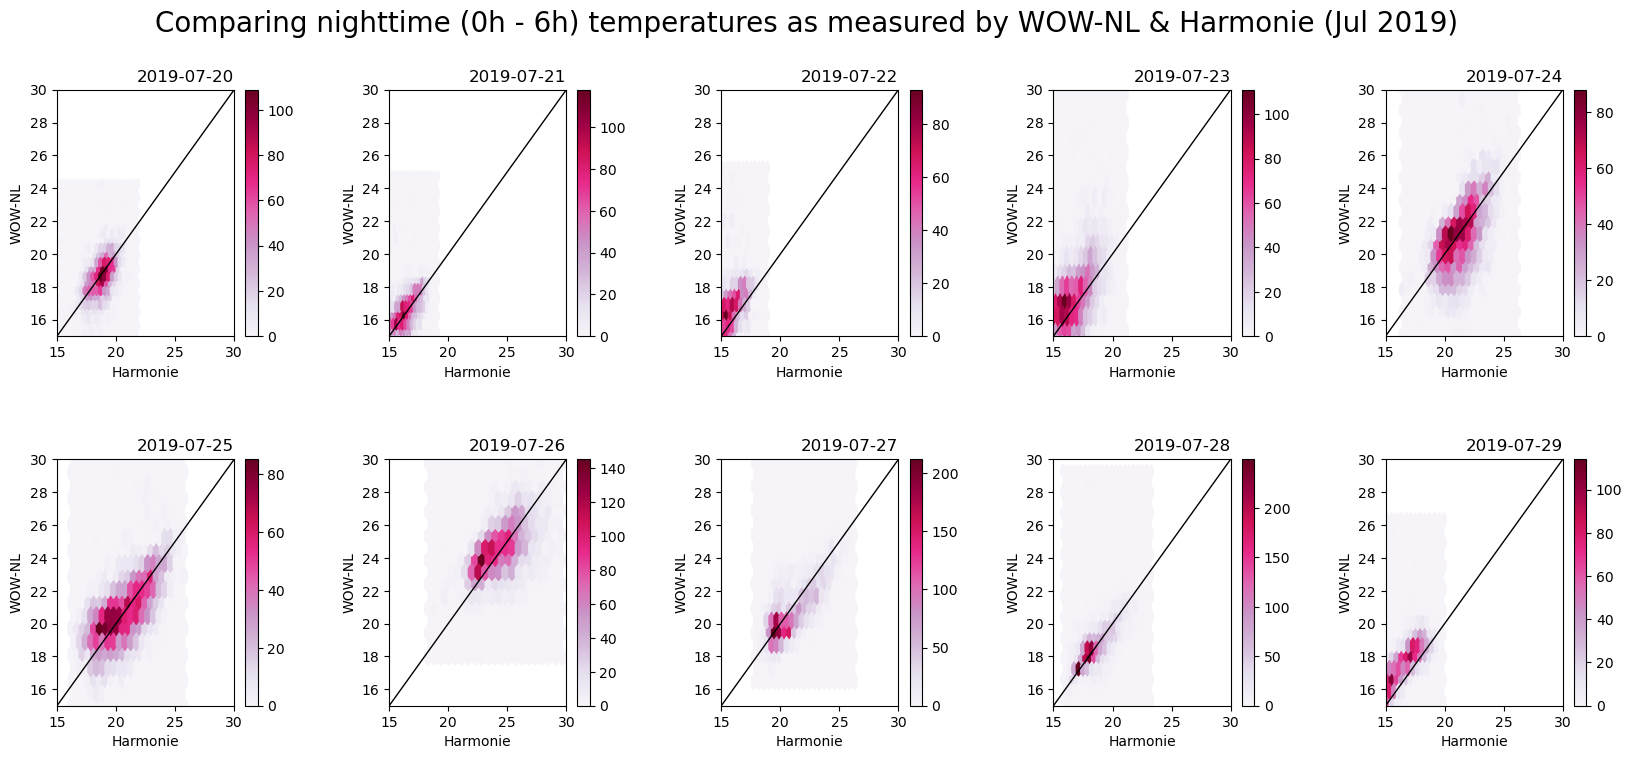

In [5]:

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
plt.suptitle("Comparing nighttime (0h - 6h) temperatures as measured by WOW-NL & Harmonie (Jul 2019)", size=20)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.xlabel("Harmonie's deterministic forecast")
# plt.ylabel("WOW-NL observations")

# fig.text(0.5, 0.04, 'Harmonie\'s deterministic forecast', ha='center')

rows = range(0, 2)
cols = range(0, 5)
pairs = list(itertools.product(rows, cols))

i = 0
for name, group in df_grouped:
    if i == 10:
        break
    
    data_wow = group["mean"]
    data_har = group["t2m_c"]    
    
    r, c = pairs[i]
    ax[r, c].set_title(str(name).split(" ")[0], loc='right') #, fontweight="bold")
    ax[r, c].set_xlim(15, 30)
    ax[r, c].set_ylim(15, 30)
    ax[r, c].plot([15, 30], [15, 30], 'black', linewidth=1)
    ax[r, c].set_xlabel("Harmonie")
    ax[r, c].set_ylabel("WOW-NL")
    bar = ax[r, c].hexbin(data_har, data_wow, gridsize = 20, cmap=plt.cm.PuRd)
    cb = fig.colorbar(bar, ax=ax[r,c])
    
    bias = np.mean(data_wow - data_har)
    noise = np.std(data_wow - data_har)
    
    print(name, np.round(bias, decimals=3), np.round(noise, decimals=3))
    
    i += 1 
    
plt.show()